In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../data/surgeries_to_predict.csv', index_col=0)
len(df)

10000

In [3]:
df.head()

,Surgery Type,Anesthesia Type,Age,BMI,DoctorID,AnaesthetistID,Duration in Minutes
0,3,1,44,20,853628,178042,149
1,0,0,56,27,369199,714022,86
2,0,1,45,22,519569,906701,81
3,1,0,63,22,230984,454178,177
4,1,0,40,35,706850,636647,127


In [4]:
train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)

In [5]:
cat_cols = ['Surgery Type',
 'Anesthesia Type',
 'DoctorID',
 'AnaesthetistID']
num_cols = ['Age', 'BMI']
target_col = 'Duration in Minutes'

In [6]:
df[cat_cols].nunique()

Surgery Type          5
Anesthesia Type       2
DoctorID           9946
AnaesthetistID     9943
dtype: int64

In [7]:
df['DoctorID'].value_counts().value_counts()

count
1    9892
2      54
Name: count, dtype: int64

In [8]:
df['AnaesthetistID'].value_counts().value_counts()

count
1    9887
2      55
3       1
Name: count, dtype: int64

## Doctor ans anaesthetist IDs
Seems that we will not be able to learn much from these two columns - we have only a few doctors that appear only _twice_, and only one anaesthetist that appears _three times_. We will probably have to drop these columns in some models.

# Baseline model - linear regression
We use it as a baseline, since it's one of the simplest models to use, and since for me it's the lowest learning curve. However, we will evaluate it according to the L1 rather than the L2 metric, since we need the predictions to schedule surgeries, and it seems that the absolute error is an appropriate choice, since we care 'by how many minutes did we miss', and not, for example, 'by how many minutes squared did we miss'

In [9]:
def get_regression_X_y(df, cat_cols, num_cols, target_col, fit_encoders=None):
    if fit_encoders is None:
        cat_col_vals = df[cat_cols].values
        cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist').fit(cat_col_vals)

        num_col_vals = df[num_cols].values
        num_encoder = StandardScaler().fit(num_col_vals)

        target = df[target_col].values
        target_encoder = StandardScaler().fit(target.reshape(-1, 1))
    else:
        cat_encoder, num_encoder, target_encoder = fit_encoders

    cat_col_vals = cat_encoder.transform(df[cat_cols].values)
    num_col_vals = num_encoder.transform(df[num_cols].values)
    target = target_encoder.transform(df[target_col].values.reshape(-1, 1))
    X = np.hstack([cat_col_vals, num_col_vals])
    y = target.ravel()
    return X, y, (cat_encoder, num_encoder, target_encoder)

In [10]:
train_linreg = train.drop(['DoctorID', 'AnaesthetistID'], axis=1)
test_linreg = test.drop(['DoctorID', 'AnaesthetistID'], axis=1)
linreg_catcols = ['Surgery Type', 'Anesthesia Type']

In [11]:
X_train, y_train, encoders = get_regression_X_y(train_linreg, linreg_catcols, num_cols, target_col)
X_test, y_test, _ = get_regression_X_y(test, linreg_catcols, num_cols, target_col, fit_encoders=encoders)

## Run linear regression and print mean absolute error

In [12]:
linreg = LinearRegression().fit(X_train, y_train)

In [13]:
y_test_pred = linreg.predict(X_test)

In [14]:
y_test_decoded = encoders[2].inverse_transform(y_test.reshape(-1, 1))
y_pred_decoded = encoders[2].inverse_transform(y_test_pred.reshape(-1, 1))

In [15]:
# just for sanity
print(f'RMSE = {math.sqrt(sklearn.metrics.mean_squared_error(y_test_decoded, y_pred_decoded))}')

RMSE = 19.155016258431083


In [16]:
print(f'Mean absolute error = {sklearn.metrics.mean_absolute_error(y_test_decoded, y_pred_decoded)}')

Mean absolute error = 16.08815221737218


## Plot the predictions vs. the actual values

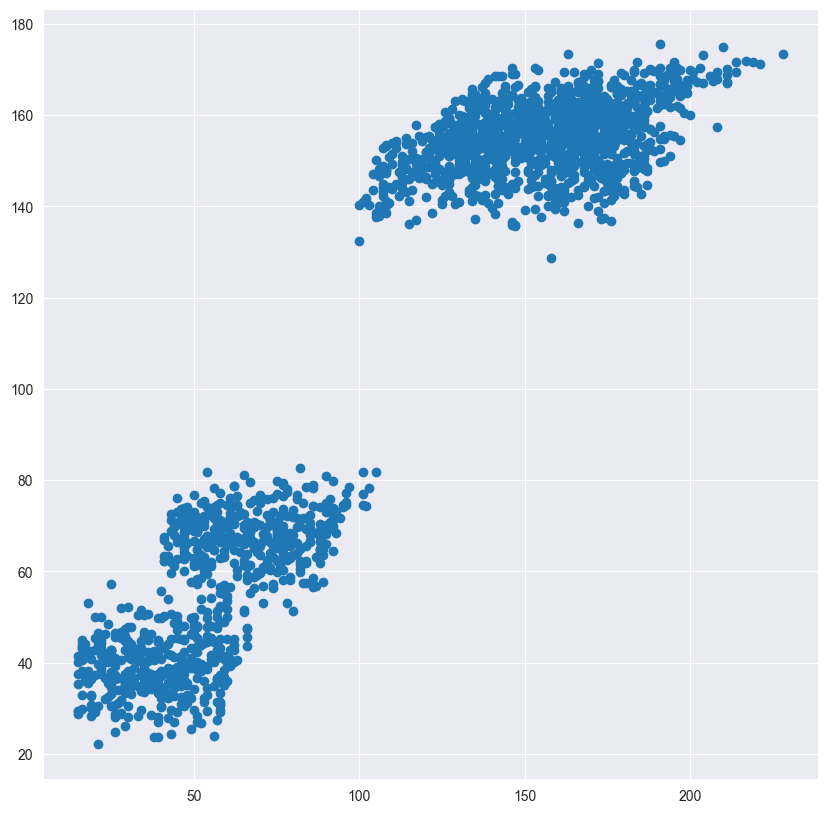

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test_decoded, y_pred_decoded)

<Axes: xlabel='Duration in Minutes', ylabel='Density'>

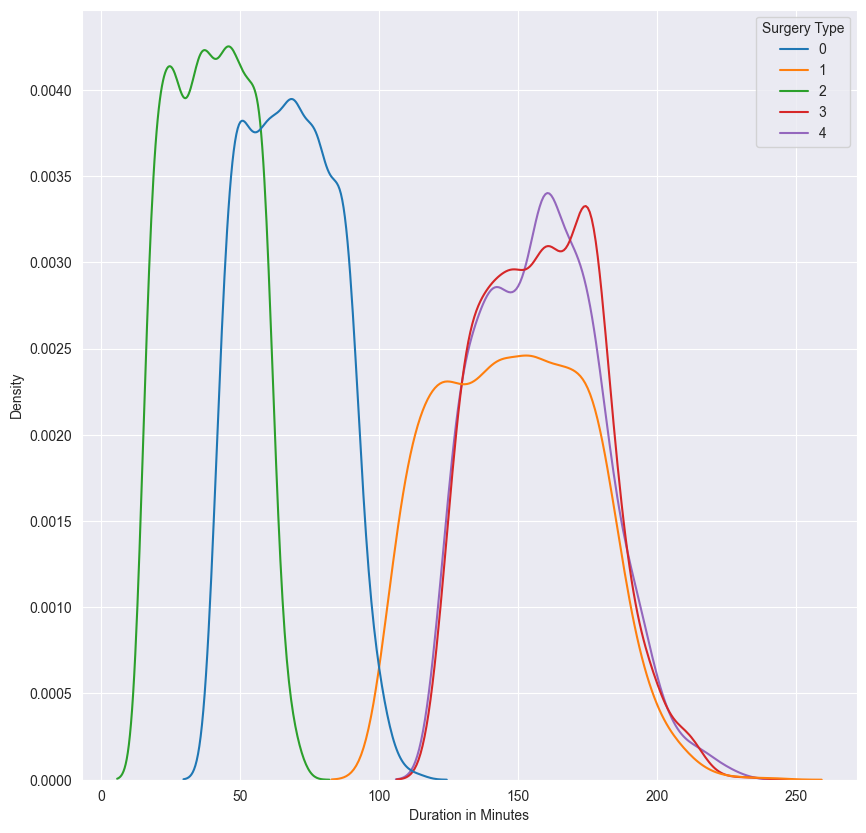

In [18]:
plt.figure(figsize=(10, 10))
sns.kdeplot(data=df, x='Duration in Minutes', hue='Surgery Type', palette='tab10')

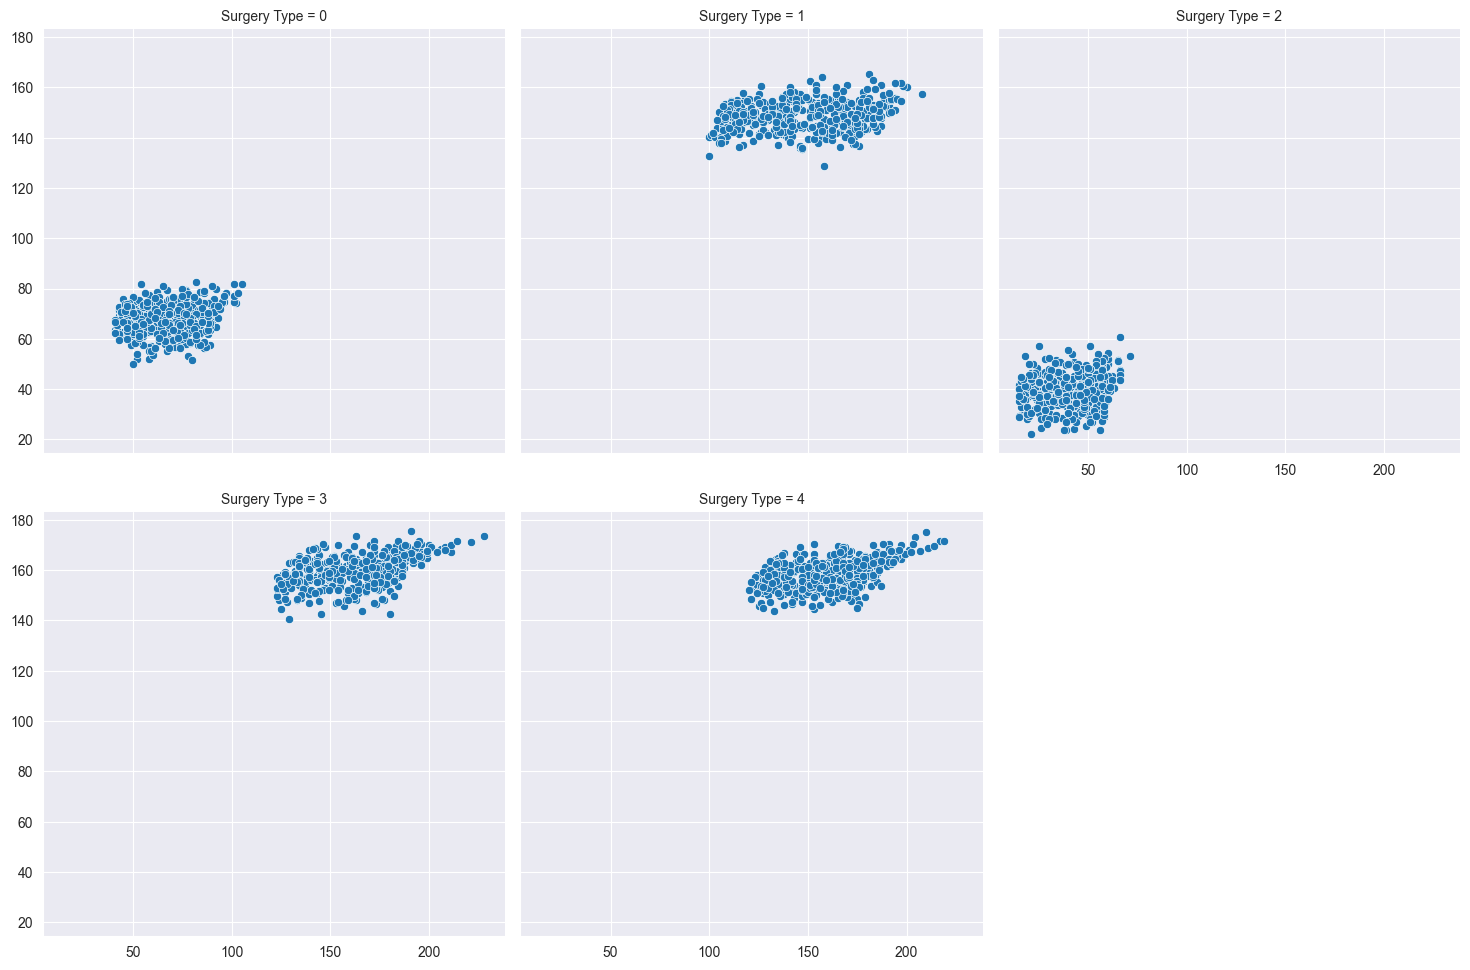

In [19]:
# We also see that the prediction quality *within* each surgery type isn't that great. The correlation is weak.
sns.relplot(x=y_test_decoded.ravel(), y=y_pred_decoded.ravel(), col=test['Surgery Type'], col_wrap=3)

# Another model - linear coefficients for each surgery type

In [20]:
linreg_pertype_catcols = ['Anesthesia Type']
surgery_types_train = train['Surgery Type'].values
surgery_types_test = test['Surgery Type'].values

In [21]:
X_train, y_train, encoders = get_regression_X_y(train_linreg, linreg_pertype_catcols, num_cols, target_col)
X_test, y_test, _ = get_regression_X_y(test, linreg_pertype_catcols, num_cols, target_col, fit_encoders=encoders)

In [22]:
def coef_per_type(X, types):
    num_of_types = 1 + np.max(types)
    result = np.zeros((X.shape[0], X.shape[1] * num_of_types))
    for i in range(X.shape[0]):
        output_col_from = X.shape[1] * types[i]
        output_col_to = X.shape[1] * (types[i] + 1)
        result[i, output_col_from:output_col_to] = X[i, :]
    return result

In [23]:
X_train_pertype = coef_per_type(X_train, surgery_types_train)
X_test_pertype = coef_per_type(X_test, surgery_types_test)

In [24]:
linreg = LinearRegression().fit(X_train_pertype, y_train)

In [25]:
y_test_pred = linreg.predict(X_test_pertype)

In [26]:
y_test_decoded = encoders[2].inverse_transform(y_test.reshape(-1, 1))
y_pred_decoded = encoders[2].inverse_transform(y_test_pred.reshape(-1, 1))

In [27]:
print(f'Mean absolute error = {sklearn.metrics.mean_absolute_error(y_test_decoded, y_pred_decoded)}')

Mean absolute error = 15.907443914589027


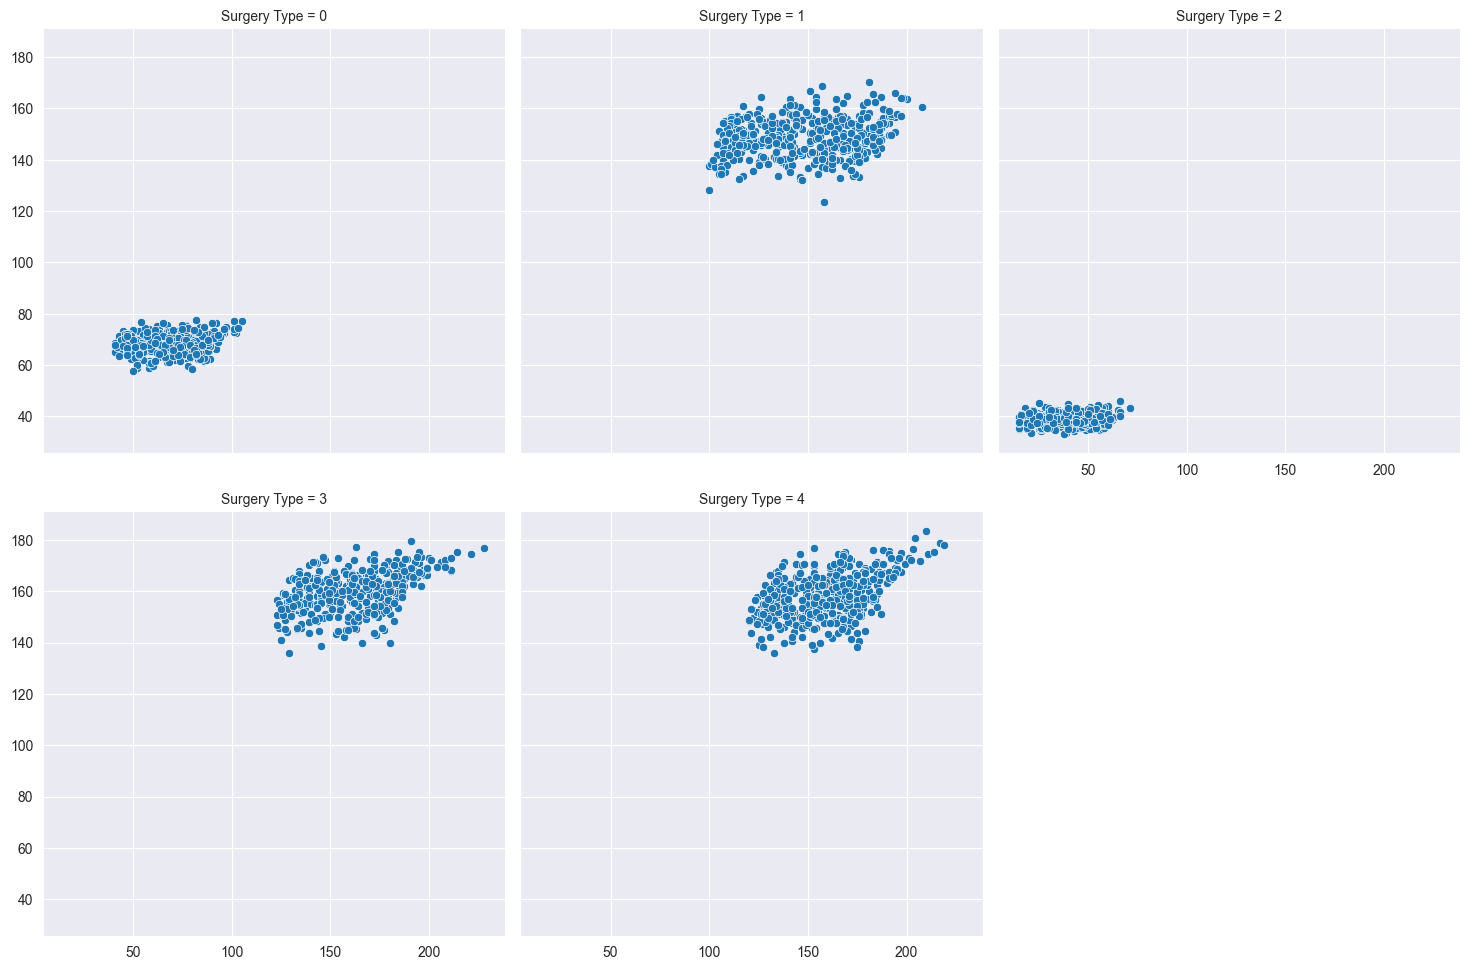

In [28]:
sns.relplot(x=y_test_decoded.ravel(), y=y_pred_decoded.ravel(), col=test['Surgery Type'], col_wrap=3)

We see a slight improvement in MAE, but the correlation still isn't great. Let's see if decision trees can do better.

# CatBoost model
Note, it directly support L1 loss, so it's even more natural to use it here.

In [29]:
from catboost import Pool, CatBoost, EFstrType

In [30]:
catboost_catcols = ['Surgery Type', 'Anesthesia Type', 'DoctorID', 'AnaesthetistID']

In [31]:
# Since catBoost uses the evaluation set to tune the model, we need to split the train set into train and eval,
# so that catboost doesn't see the test set at all.
train_no_eval = train.sample(frac=0.8, random_state=43)
train_eval = train.drop(train_no_eval.index)

In [32]:
catboost_train_X = train_no_eval.drop('Duration in Minutes', axis=1)
catboost_train_y = train_no_eval['Duration in Minutes']

catboost_eval_X = train_eval.drop('Duration in Minutes', axis=1)
catboost_eval_y = train_eval['Duration in Minutes']

catboost_test_X = test.drop('Duration in Minutes', axis=1)
catboost_test_y = test['Duration in Minutes']

In [33]:
catboost_train_pool = Pool(catboost_train_X, catboost_train_y, cat_features=catboost_catcols)
catboost_eval_pool = Pool(catboost_eval_X, catboost_eval_y, cat_features=catboost_catcols)
catboost_test_pool = Pool(catboost_test_X, catboost_test_y, cat_features=catboost_catcols)

In [34]:
param = {'loss_function':'MAE'}

In [35]:
model = CatBoost(param)
model.fit(catboost_train_pool, eval_set=catboost_eval_pool)

0:	learn: 45.9310318	test: 46.1207928	best: 46.1207928 (0)	total: 57.6ms	remaining: 57.5s
1:	learn: 44.7501326	test: 44.9608225	best: 44.9608225 (1)	total: 61.9ms	remaining: 30.9s
2:	learn: 43.6106715	test: 43.8426993	best: 43.8426993 (2)	total: 65ms	remaining: 21.6s
3:	learn: 42.5216459	test: 42.7742769	best: 42.7742769 (3)	total: 66.3ms	remaining: 16.5s
4:	learn: 41.4717652	test: 41.7428978	best: 41.7428978 (4)	total: 67.6ms	remaining: 13.5s
5:	learn: 40.4578838	test: 40.7480469	best: 40.7480469 (5)	total: 68.9ms	remaining: 11.4s
6:	learn: 39.4812108	test: 39.7874328	best: 39.7874328 (6)	total: 72.3ms	remaining: 10.3s
7:	learn: 38.5237862	test: 38.8366575	best: 38.8366575 (7)	total: 74.7ms	remaining: 9.26s
8:	learn: 37.6006142	test: 37.9283994	best: 37.9283994 (8)	total: 80.7ms	remaining: 8.89s
9:	learn: 36.7235657	test: 37.0638513	best: 37.0638513 (9)	total: 83.4ms	remaining: 8.25s
10:	learn: 35.8635980	test: 36.2202646	best: 36.2202646 (10)	total: 85.3ms	remaining: 7.67s
11:	learn:

In [36]:
y_test_pred = model.predict(catboost_test_pool)

In [37]:
print(f'Mean absolute error = {sklearn.metrics.mean_absolute_error(catboost_test_y, y_test_pred)}')

Mean absolute error = 15.696622307673183


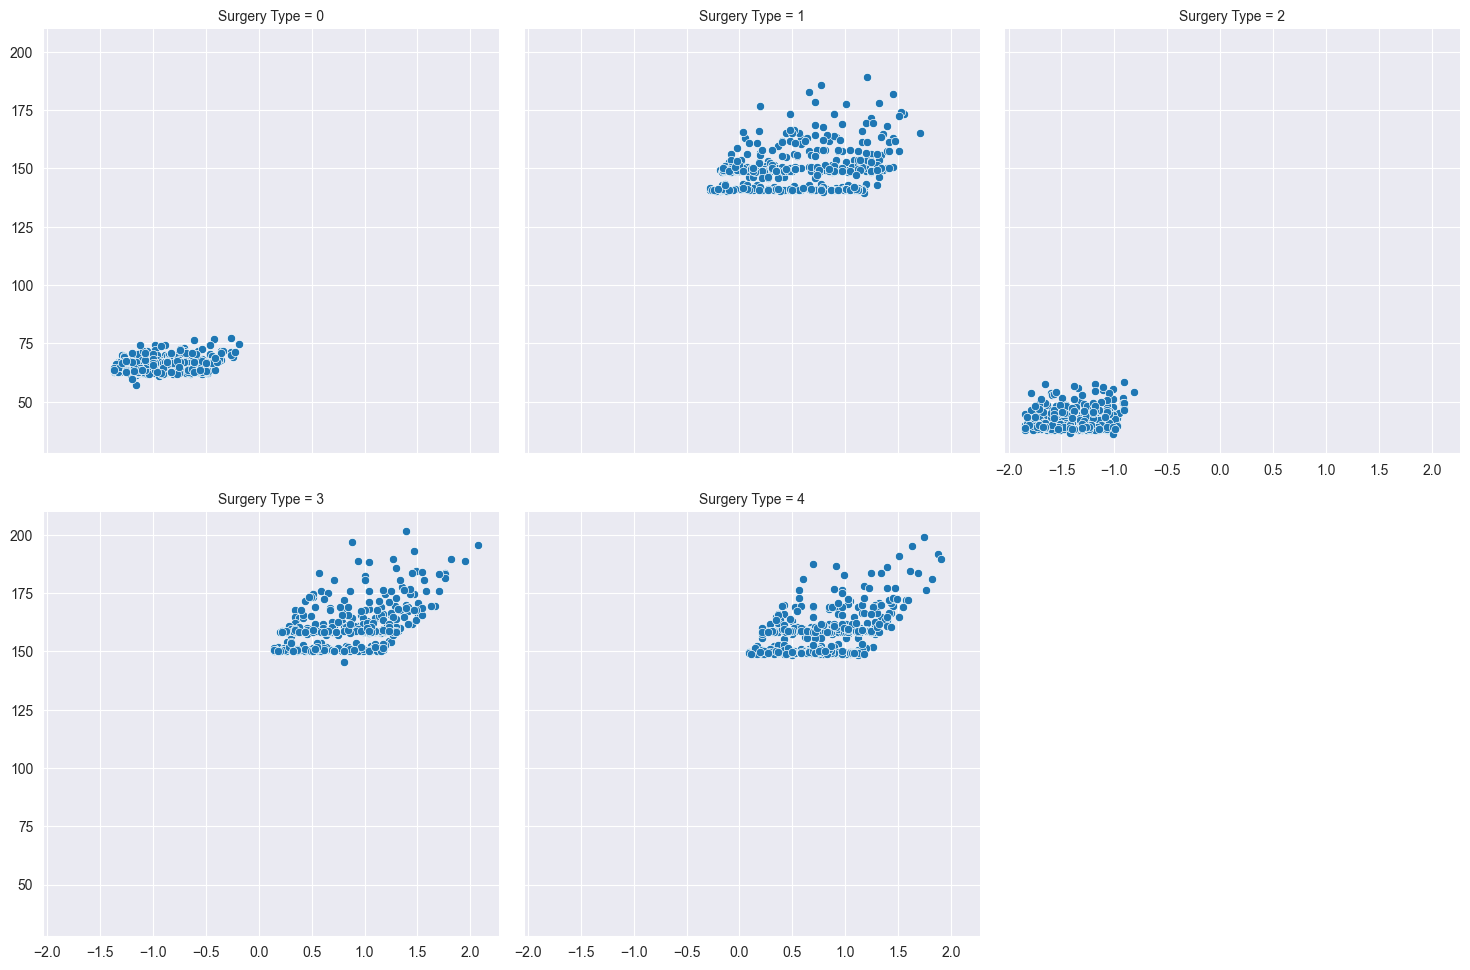

In [38]:
sns.relplot(x=y_test, y=y_test_pred, col=test['Surgery Type'], col_wrap=3)

In [39]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Surgery Type,90.965206
1,Age,4.607762
2,Anesthesia Type,3.345280
3,BMI,0.848098
4,DoctorID,0.141727
5,AnaesthetistID,0.091927


Apparently, the three most important features are surgery tyoe (as we already saw), age, and anesthesia type. Doctor ID and Anaeasthetist ID are negligible.

# Given more time
- Try a factorization machine. They are pretty good at tabular data and modeling of feature interactions, even if the data is sparse.
- Tune the catboost model, or try a different tree implementation.
- An idea from Kaggle winners: train a catboost model, use tree + node index as a feature in a sub-sequent model (FM or a linear model).
- Add a column of BMI / Age. Trees are known to weakly discover relationships that involve feature ratios.